# Deep dynamic modeling with just two timepoints - can we still get individual trajectories? 

## Exemplary application: A setting in epidemiological cohort studies and clinical registries

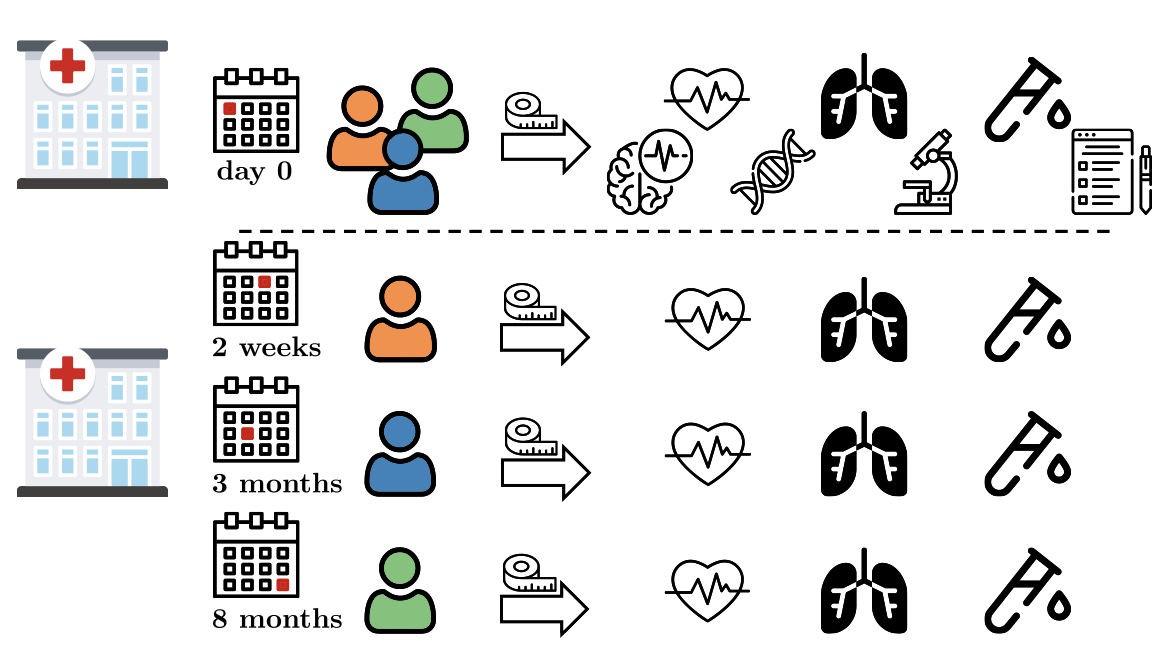

Especially in the beginning, when setting up new cohorts or registries, a typical situation might be that only baseline measurements and a single further measurement time point are available for each individual and we are facing the question of what can be learned from the data in such an early phase of the study, when only a baseline characterization and one follow-up measurement are available. 

Such a scenario is illustrated exemplarily in the figure above, where we encounter the following scenario: A group of study participants comes to the study center at a baseline timepoint, say $t_0$, where a lot of measurements is taken from them. Then, each individual comes back at a second time point to obtain measurements of only a subset of the larger number of baseline variables. However, this second measurement time point varies for different individuals, i.e., the time spans between first (baseline) and second (follow-up) measurement vary between individuals and range from a few days or weeks up to several month. 

So, instead of having repeated measurements of the same quantity, we are rather observing individual temporal development patterns measured at only two timepoints.

Our aim was to develop a model that can from data like that extract individual temporal development patterns despite the irregularity and sparsity of the time grid. 

So, to further investigate, let's first simulate some data and look at it:

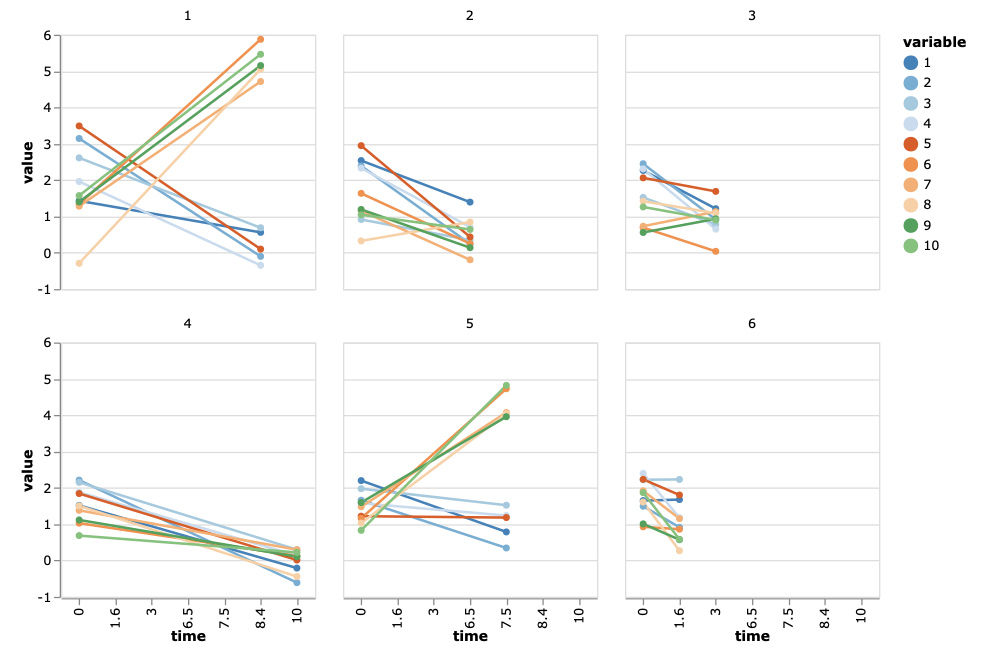

**Three central features:**
   - different second measurement time points
   - distinct development patterns
   - groups of variables that share common trends --> lower-dimensional underlying structure

To model this, we came up with the following:

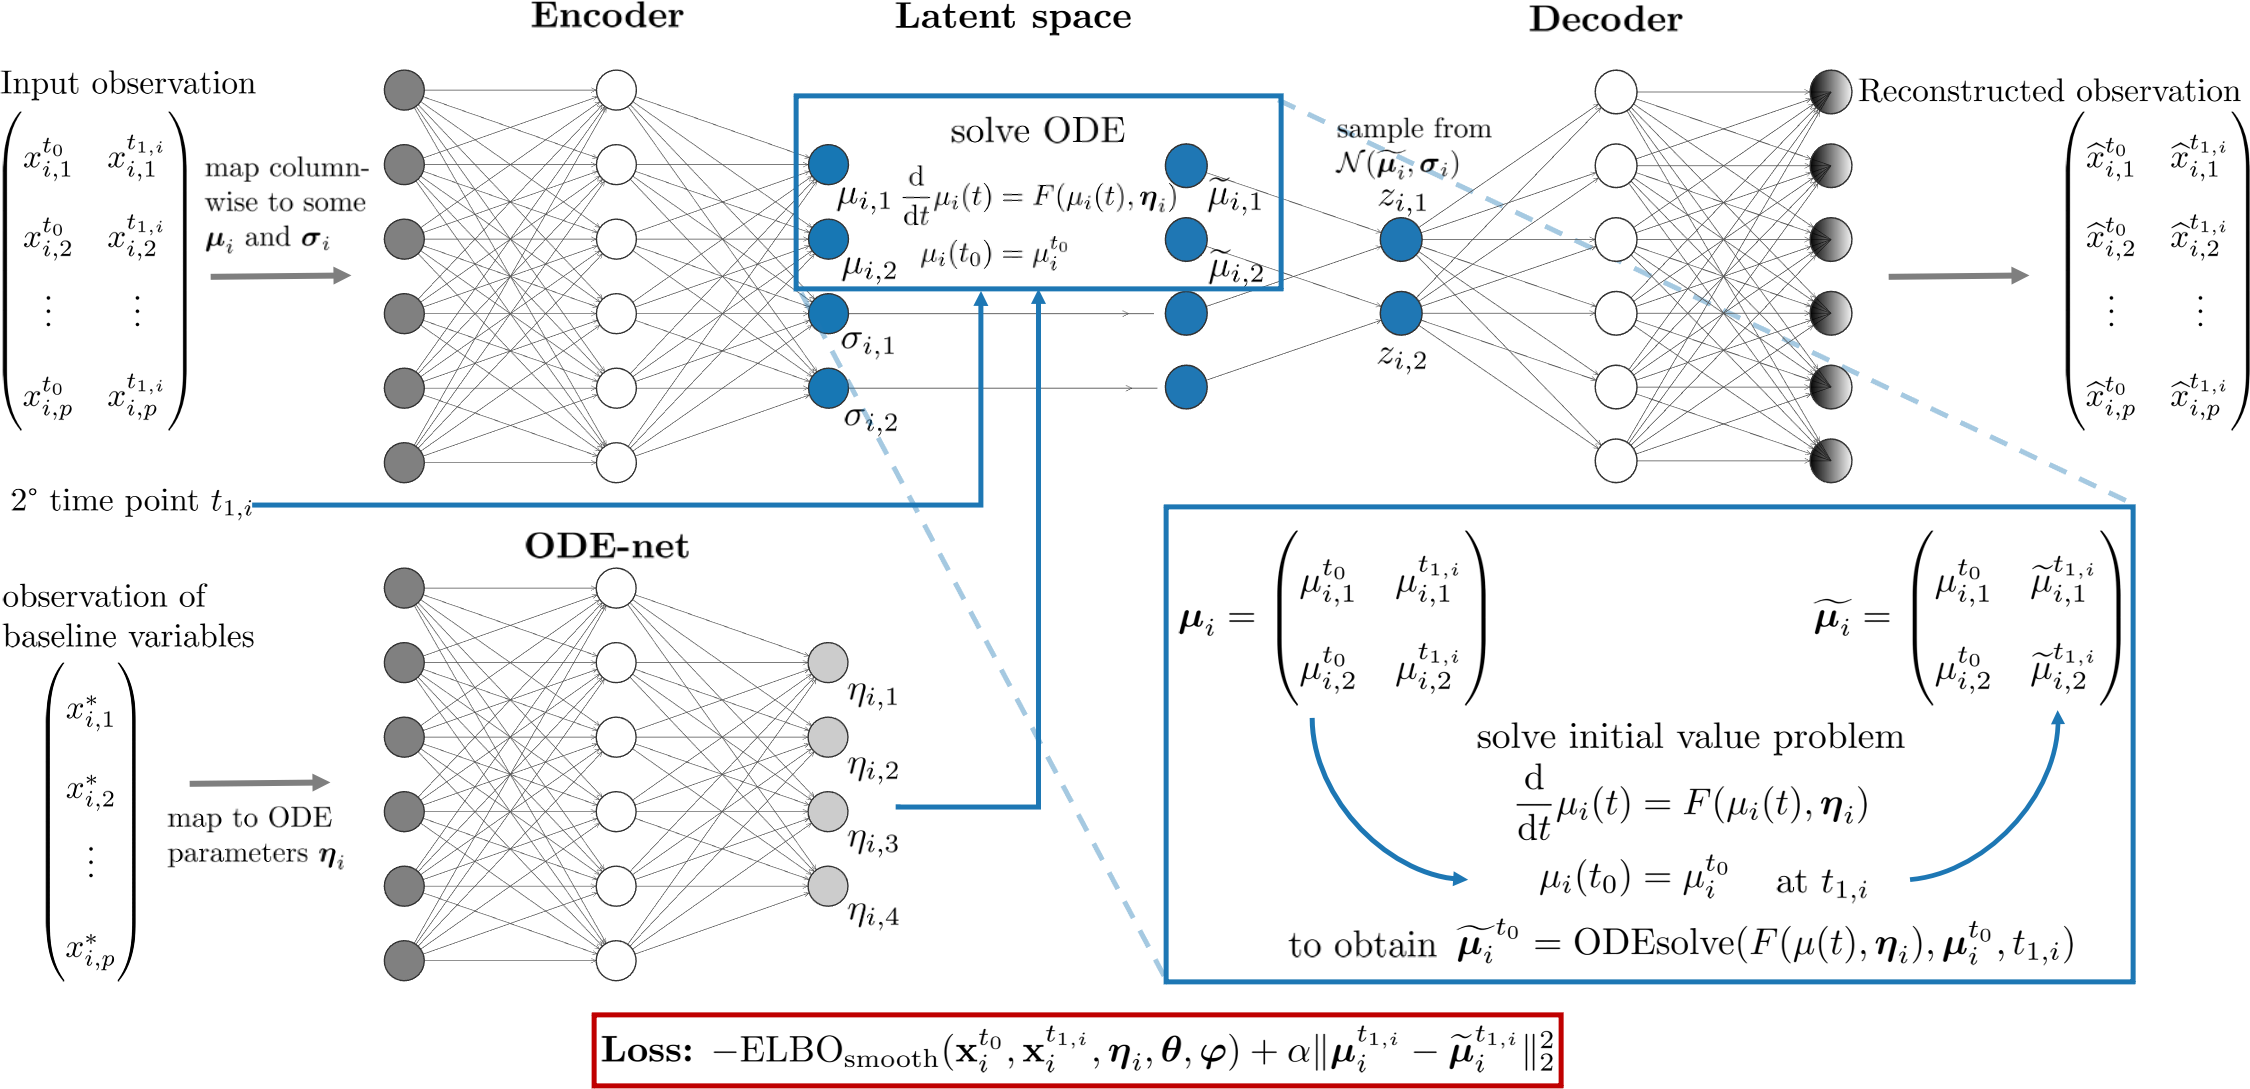

(For the details, have a look at our [preprint](https://arxiv.org/abs/2012.00634))

For now, let's see whether the model actually works! 

## Simulation design 

For that, we have designed a simulation design: We define the true latent developments as solutions of ODE systems and simulate data basically by sampling from the true ODE solution trajectories, i.e. adding some random noise to the true trajectories. Then, we try to recover the ground-truth developments with our model. 

### Setup 

First, we set up the Julia environment and the necessary packages and import user-defined functions for simulating the data, building and training the model, and visualizing the data and the learned trajectories. 

In [1]:
cd("../src")
using Pkg;
Pkg.activate(".")
Pkg.instantiate()
Pkg.status()

 Activating environment at `/Users/maren/Projects/Masterarbeit/GithubRepo/DeepDynamicModelingWithJust2TimePoints/Project.toml`


Status `/Users/maren/Projects/Masterarbeit/GithubRepo/DeepDynamicModelingWithJust2TimePoints/Project.toml`
  [336ed68f] CSV v0.8.4
  [a93c6f00] DataFrames v0.22.7
  [aae7a2af] DiffEqFlux v1.35.1
  [0c46a032] DifferentialEquations v6.16.0
  [31c24e10] Distributions v0.24.15
  [587475ba] Flux v0.11.2
  [b964fa9f] LaTeXStrings v1.2.1
  [429524aa] Optim v1.3.0
  [bac558e1] OrderedCollections v1.4.0
  [91a5bcdd] Plots v1.12.0
  [2913bbd2] StatsBase v0.33.5
  [112f6efa] VegaLite v2.4.0
  [e88e6eb3] Zygote v0.5.17


In [2]:
using Distributions
using Random
using Flux
using DiffEqFlux
using Optim
using DifferentialEquations
using Plots 
using LaTeXStrings
gr()

Plots.GRBackend()

In [3]:
include("simulation.jl")
include("model.jl")
include("plotting.jl")

create_cohortplot (generic function with 1 method)

### Simulate the data 

The ground-truth developments that we try to recover with our model are defined as solutions of linear 2-dimensional ODE systems. 

We first define the system and two the corresponding ODE problems with distinct parameters, corresponding to two distinct development patterns.

In [4]:
# define true underlying ODE system
function linear_2d_system(du,u,p,t)
    a11, a12, a21, a22 = p
    z1,z2 = u
    du[1] = dz1 = a11 * z1 + a12 * z2
    du[2] = dz2 = a21 * z1 + a22 * z2
end
  
# define initial condition
true_u0 = Float32[2, 1]
# define time span on which to solve the ODE
tspan = (0.0f0, 10.0f0)
# define parameters for the two distinct groups
true_odeparams_group1 = Float32[-0.2, 0.00, 0.00, -0.2]
true_odeparams_group2 = Float32[-0.2, 0.00, 0.00, 0.2]
  
# define corresponding ODE problems for the two groups
prob1 = ODEProblem(linear_2d_system,true_u0,tspan,true_odeparams_group1)
prob2 = ODEProblem(linear_2d_system,true_u0,tspan,true_odeparams_group2)

ODEProblem with uType Array{Float32,1} and tType Float32. In-place: true
timespan: (0.0f0, 10.0f0)
u0: 2-element Array{Float32,1}:
 2.0
 1.0

Now, we can solve the ODE systems and look at the solutions for poth patterns. 

┌ Info: Precompiling GR_jll [d2c73de3-f751-5644-a686-071e5b155ba9]
└ @ Base loading.jl:1278


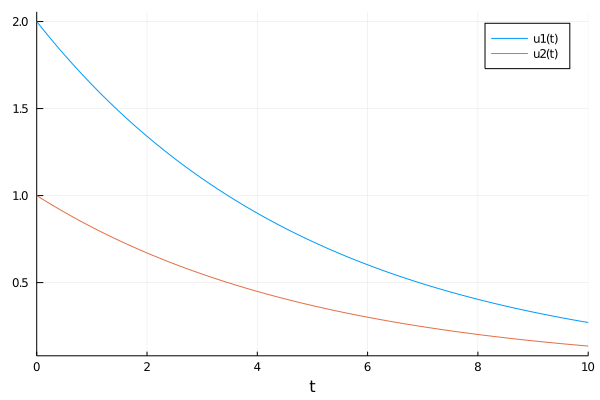

In [5]:
# solve ODE systems to obtain "true" underlying trajectory in each group
dt=0.1
sol_group1 = solve(prob1, Tsit5(), saveat = dt);
sol_group2 = solve(prob2, Tsit5(), saveat = dt);
plot(sol_group1)

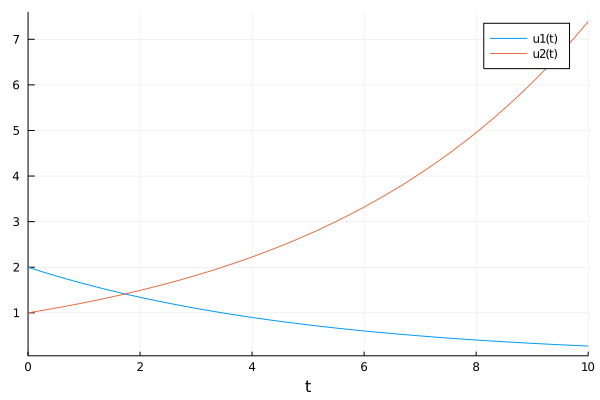

In [6]:
plot(sol_group2)

Now, we simulate data of 'n' individuals by adding noise to the true development patterns:

First, we randomly assign each individual into one of two groups, corresponding to the two distinct development patterns `sol_group1` and `sol_group2` created above. 

Next, for each simulated individual, we randomly draw a second measurement time point (or several subsequent random measurement time points) between `t_start`(default: 1.5) and `t_end` (default: 10) (here, `t_start`, `t_end`  $\in$ `tspan` is necessary). 

Then, for each individual, we simulate `p` measurements of each dimension of the ODE solution, i.e., for a 2-dimensional ODE system as in this example, we have $2*$ `p` variables. We do this by adding a variable-specific and an individual-specific measurement error to the true ODE solution of the individual's group at the individual-specific second measurement time point. These errors are drawn from to $\mathcal{N}(0,\sigma_{\mathrm{var}})$ and $\mathcal{N}(0,\sigma_{\mathrm{ind}})$, respectively.

In [7]:
# define numbers of individuals and variables 
n = 100 
p = 10
q, q_info = 50, 10

# choose simulation setting for baseline variables 
baseline_simulation = "trueparams" # alternative: "groupsonly"

# set seed for reproducibility
Random.seed!(12);

# generate time dependent variables
xs, tvals, group1, group2 = generate_xs(n, p, true_u0, sol_group1, sol_group2); 
# default vals: t_start=1.5, t_end=10, maxntps=10, dt=0.1, σ_var=0.1, σ_ind=0.5

Finally, we generate the corresponding baseline variables that reflect are more extensive characterization of the individuals at the baseline time point $t_0$. Here, we distinguish between two possibilites of either drawing from the true ODE parameters with some added random noise, or drawing from the group membership information encoded as $\pm 1$ with random noise. In both scenarios, we simulate `q_info` variable with that noisy information about either the ODE parameters or the group membership, and simulate additional variables that contain purely random noise, until we end up with a total of `q` baseline variables.  

In [8]:
# generate baseline variables
if baseline_simulation == "trueparams"
    x_baseline = generate_baseline(n, q, q_info, group1, true_odeparams_group1, true_odeparams_group2); 
    # defaul vals: σ_info=0.1, σ_noise=0.1
elseif baseline_simulation == "groupsonly"
    x_baseline = generate_baseline(n, q, q_info, group1); 
    # default vals: σ_info=1, σ_noise=1
else
    error("Please select either 'trueparams' or 'groupsonly' as mode for simulation of baseline variables")
end

100-element Array{Array{Float64,1},1}:
 [-0.31884491556084277, -0.04316820837006724, -0.24447674860966054, -0.0838381433792342, -0.22626893271125575, -0.05563905083603696, -0.22626249350849048, -0.08352580455213052, -0.1889251466388373, -0.15937830196278951  …  0.2183064220884474, -0.12257850912900559, -0.08430206995522911, 0.09607276305203584, 0.1347347634268949, -0.14717876343255035, 0.11822458853987863, 0.038151665739690255, -0.006583399854764176, -0.017356556922568534]
 [-0.3090322195984833, -0.12669009475777926, -0.2652384944340137, -0.18135022192241157, -0.2909970982539735, 0.47501225786523216, 0.21591182402937553, 0.2945794628894876, 0.028719161291206025, 0.08503171493983872  …  -0.09334060812536976, 0.24669680577920966, -0.032071458319151855, -0.0989099288761091, -0.05638495016625725, -0.09075229922002687, 0.019033551045547343, -0.07387837233608273, -0.2012469405896812, 0.029199233024197274]
 [-0.14489737883788556, 0.045196160572947675, -0.11866526615787443, -0.1978499542489661

Let's have a look at the data we generated (showing only the true ODE solutions as lines and the first row and the solutions and drawn measurements as dots in the second row), separately for each group (=column).

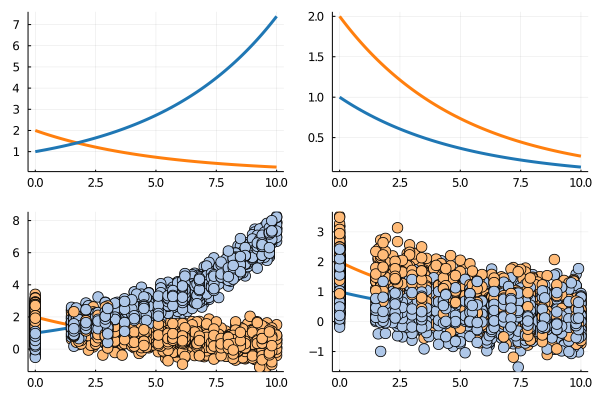

In [9]:
# look at data: 
data = simdata(xs, x_baseline, tvals, group1, group2);

plot(plot_truesolution(2, data, sol_group1, sol_group2, showdata=false), 
    plot_truesolution(1,  data, sol_group1, sol_group2, showdata=false), 
    plot_truesolution(2, data, sol_group1, sol_group2, showdata=true), 
    plot_truesolution(1,  data, sol_group1, sol_group2, showdata=true),
    layout = (2,2),
    legend = false
)

## Define model 

Next, let's define our model and how to initialize it by specifying the neural network architectures of the encoder, decoder and the ODE-net mapping the baseline variables to the individual-specific ODE parameters.

In [10]:
mutable struct odevae
    p 
    q
    zdim 
    paramNN
    encoder
    encodedμ 
    encodedlogσ 
    decoder
    decodedμ 
    decodedlogσ 
    ODEprob
end

In [11]:
# initialise model
function init_vae(p, q, zdim, nODEparams, ODEprob; seed::Int=1234)
    # seed
    Random.seed!(seed)
    # parameter network
    paramNN = Chain(Dense(q,q,tanh), Dense(q,nODEparams, arg ->(sigmoid(arg).-0.5)), Flux.Diagonal(nODEparams)) #.*10 vorher
    #   VAE encoder
    Dz, Dh = zdim, p
    encoder, encodedμ, encodedlogσ = Dense(p, Dh, arg ->(tanh.(arg) .+ 1)), Dense(Dh, Dz), Chain(Dense(Dh, Dz, arg -> -relu(arg)), Flux.Diagonal(Dz))
    # VAE decoder
    decoder, decodedμ, decodedlogσ = Dense(Dz, Dh, tanh), Dense(Dh, p), Dense(Dh, p)

    model = odevae(p, q, zdim, paramNN, encoder, encodedμ, encodedlogσ, decoder, decodedμ, decodedlogσ, ODEprob)
    return model
end

init_vae (generic function with 1 method)

Next, we define the model loss: We augment the classical VAE loss given by the negative evidence lower bound (ELBO) by adding a term that enforces consistency of latent representation before solving the ODE (=obtained directly from putting the data from subsequent measurement time points through the VAE encoder) and after solving the ODE with the individual-specific parameters obtained from the ODE-net and the baseline variables. 

In [12]:
latentz(μ, logσ) = μ .+ sqrt.(exp.(logσ)) .* randn(Float32,size(μ)...) # sample latent z,

kl_q_p(μ, logσ) = 0.5 .* sum(exp.(logσ) + μ.^2 .- 1 .- (logσ),dims=1)

logp_x_z(m::odevae, x, z) = sum(logpdf.(Normal.(m.decodedμ(m.decoder(z)), sqrt.(exp.(m.decodedlogσ(m.decoder(z))))), x),dims=1) # get reconstruction error

sqnorm(x) = sum(abs2, x)

reg(m::odevae) = sum(sqnorm, Flux.params(m.decoder,m.decodedμ,m.decodedlogσ)) # regularisation term in loss

getparams(m::odevae) = Flux.params(m.encoder, m.encodedμ, m.encodedlogσ, m.decoder, m.decodedμ, m.decodedlogσ, m.paramNN) # get parameters of VAE model

function loss(X, Y, t, m::odevae)
    latentμ, latentlogσ = m.encodedμ(m.encoder(X)), m.encodedlogσ(m.encoder(X))
    learnedparams = m.paramNN(Y)
    curparams = [learnedparams[1], 0.00, 0.00, learnedparams[2]]
    curts = Int.(floor.(t .*(1 ./dt) .+1))
    smoothμ = Array(solve(m.ODEprob, Tsit5(), u0 = [latentμ[1,1], latentμ[2,1]], p=curparams, saveat=dt))[:,curts]
    #smoothμ = Tracker.collect(enode(latentμ[1,1], latentμ[2,1], curparams, curt))
    combinedμ = hcat(latentμ[:,1],smoothμ)
    combinedz = latentz.(combinedμ, latentlogσ)
    ELBO = 1.0 .* logp_x_z(m, X, combinedz) .- 0.5 .* kl_q_p(combinedμ, latentlogσ)
    lossval = sum(-ELBO) + 0.01*reg(m) + 0.5*sum((smoothμ .- latentμ[:,2:end]).^2)
    return lossval
end

function loss_wrapper(m::odevae) 
    return function (X, Y, t) loss(X, Y, t, m) end 
end

loss_wrapper (generic function with 1 method)

## Train model!

Now it's time to train the model: We initialise it and define some callback functions to monitor and visualize the training process, before starting the training loop.

### Instantiate 

In [13]:
zdim = nODEparams = 2
m = init_vae(p, q, zdim, nODEparams, prob1)
L = loss_wrapper(m)
ps = getparams(m)
opt = ADAM(0.0005)
trainingdata = zip(xs, x_baseline, tvals);
evalcb() = @show(mean(L.(xs, x_baseline, tvals)))
evalcb_zs() = eval_z_trajectories(xs, x_baseline, tvals, group1, sol_group1, sol_group2, m, dt)

evalcb_zs (generic function with 1 method)

### Train

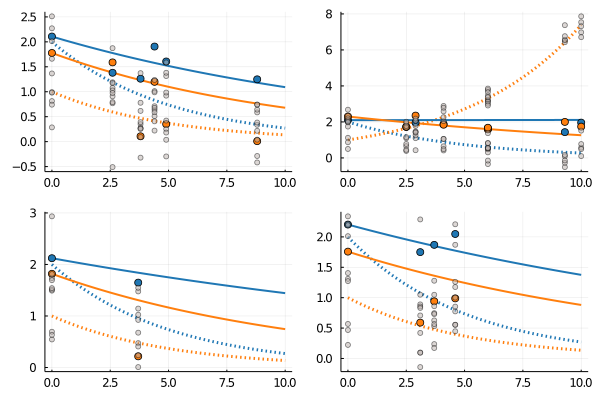

mean(L.(xs, x_baseline, tvals)) = 199.6205929689405
mean(L.(xs, x_baseline, tvals)) = 

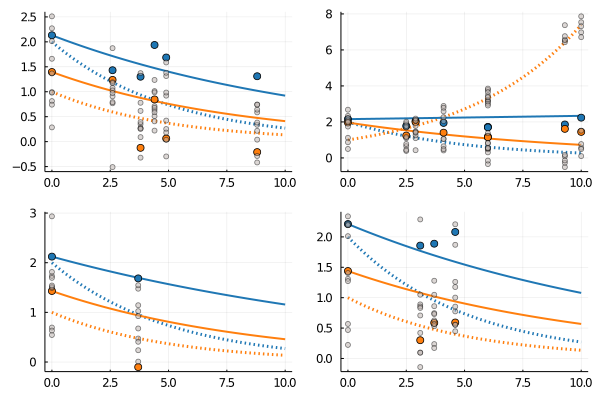

170.66052239749976


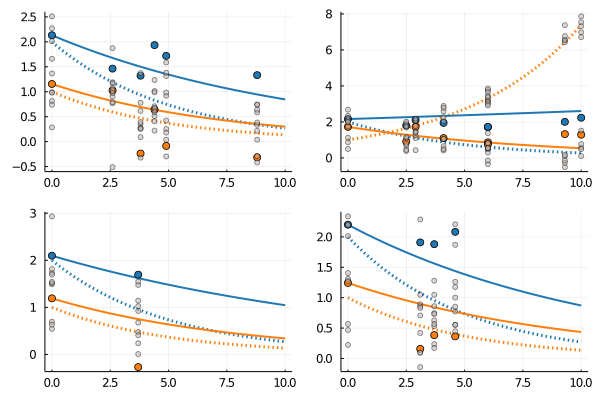

mean(L.(xs, x_baseline, tvals)) = 152.91746280144633
mean(L.(xs, x_baseline, tvals)) = 

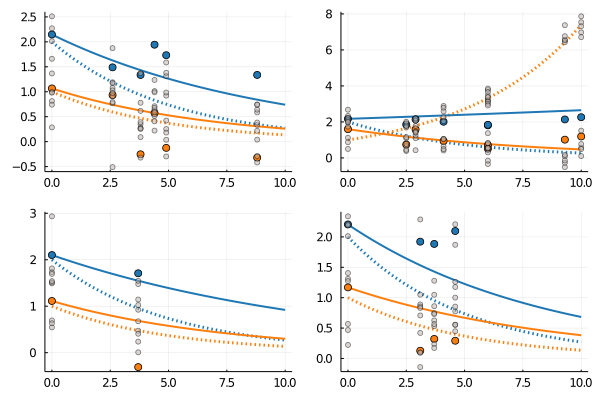

140.99180840001674


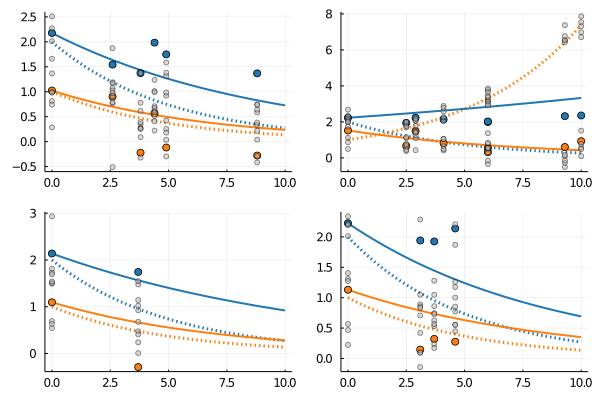

mean(L.(xs, x_baseline, tvals)) = 132.84880773432116
mean(L.(xs, x_baseline, tvals)) = 

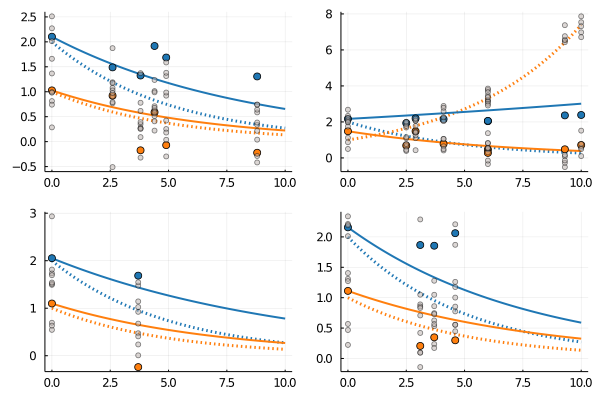

126.97334201194293


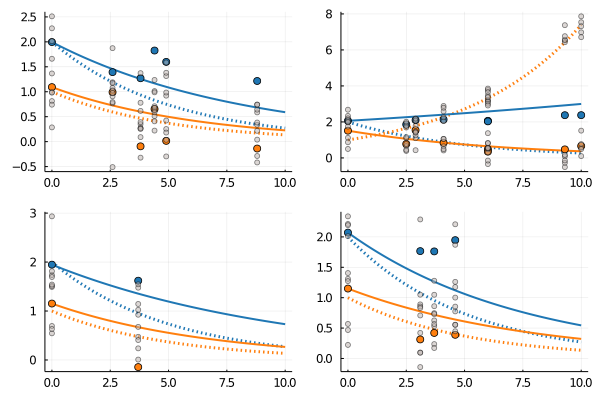

mean(L.(xs, x_baseline, tvals)) = 123.30692677766798
mean(L.(xs, x_baseline, tvals)) = 

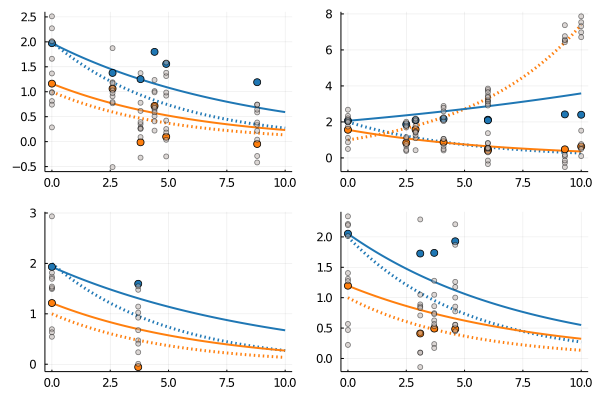

118.23098751316222


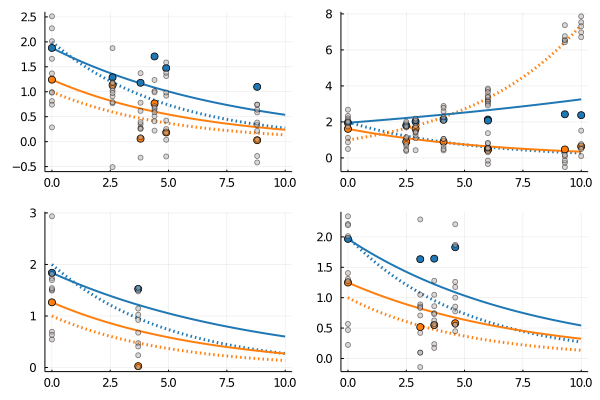

mean(L.(xs, x_baseline, tvals)) = 114.38942591621955
mean(L.(xs, x_baseline, tvals)) = 

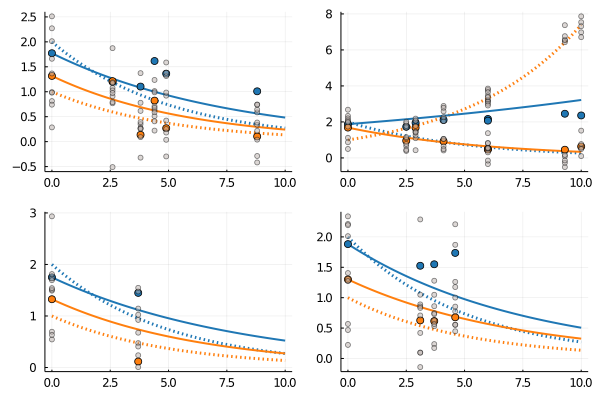

114.06599896868416


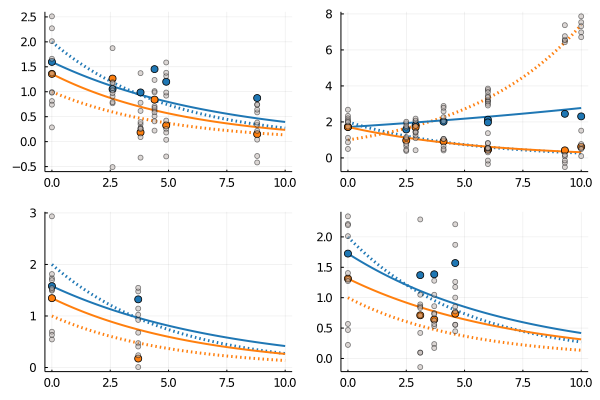

mean(L.(xs, x_baseline, tvals)) = 110.64212577932813
mean(L.(xs, x_baseline, tvals)) = 

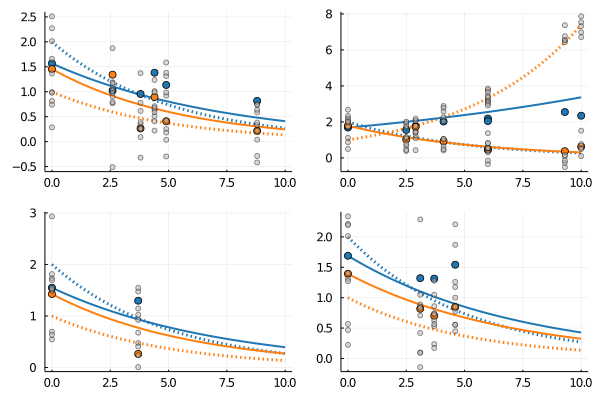

109.51944295953164


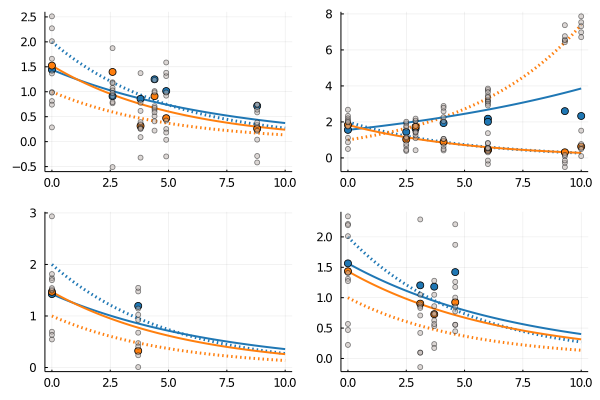

mean(L.(xs, x_baseline, tvals)) = 107.364794352317
mean(L.(xs, x_baseline, tvals)) = 

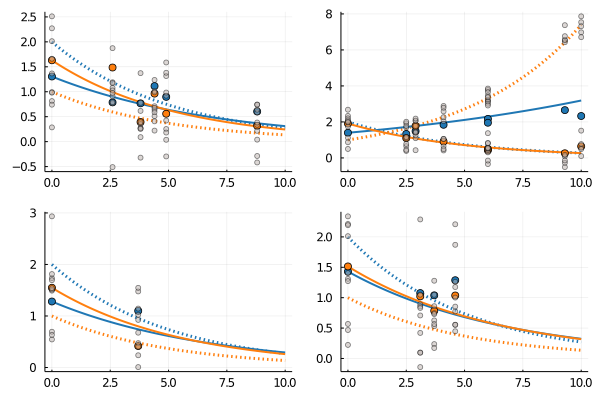

104.68010422470135


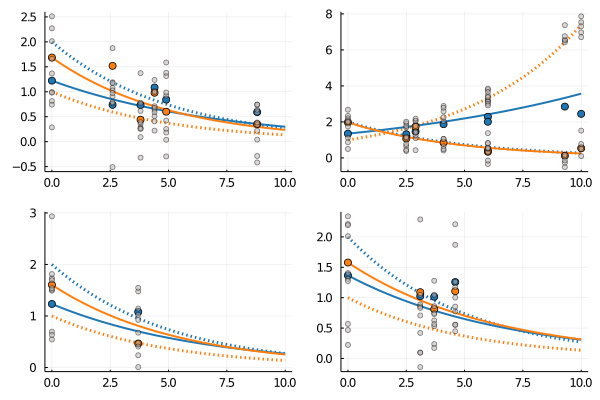

mean(L.(xs, x_baseline, tvals)) = 103.3909599224517
mean(L.(xs, x_baseline, tvals)) = 

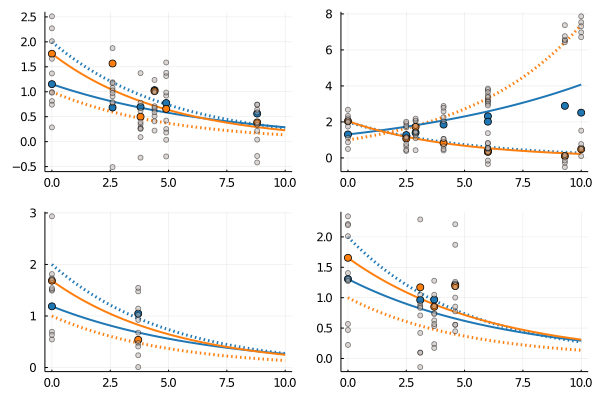

102.60700524635209


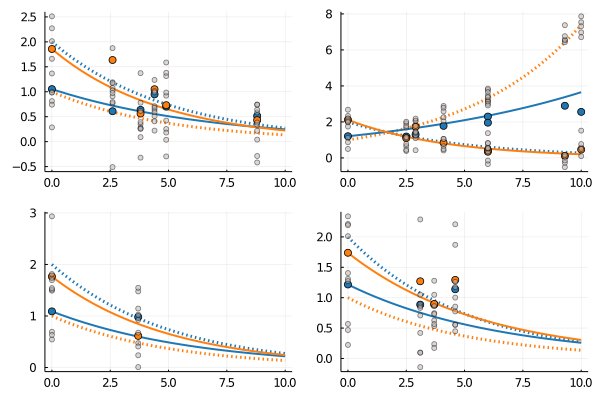

mean(L.(xs, x_baseline, tvals)) = 101.56719111172238
mean(L.(xs, x_baseline, tvals)) = 

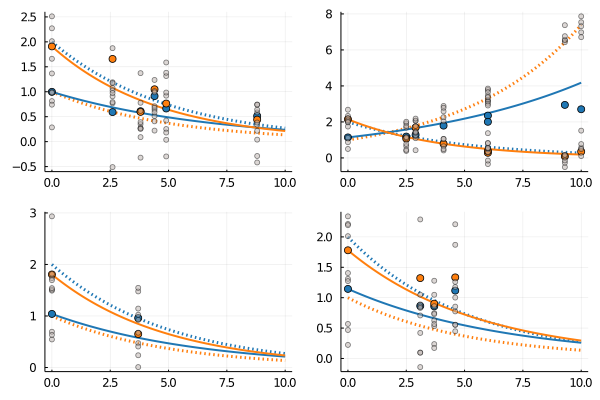

99.51409045115193


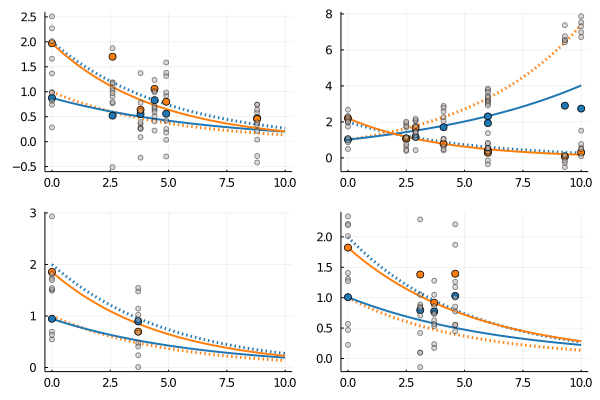

mean(L.(xs, x_baseline, tvals)) = 98.9347055809452
mean(L.(xs, x_baseline, tvals)) = 

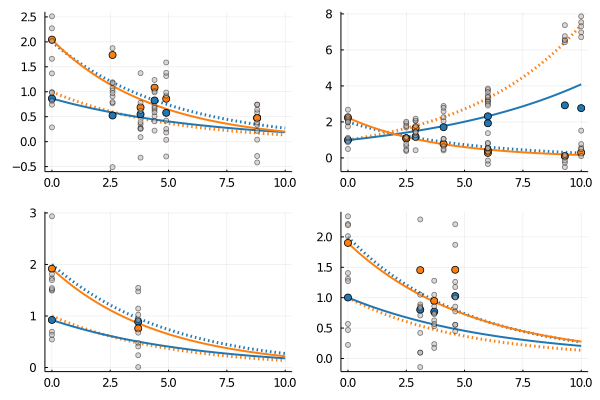

97.10958554384062


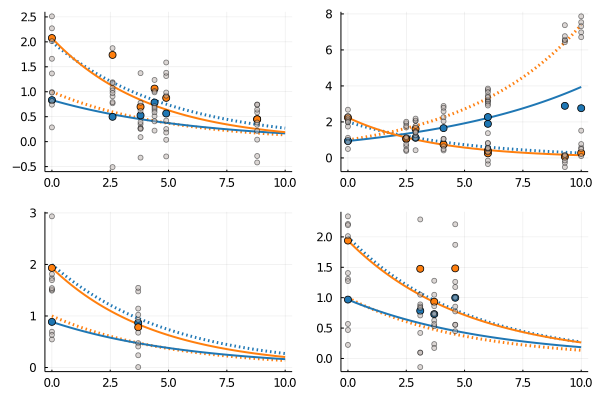

mean(L.(xs, x_baseline, tvals)) = 98.10190615514493
mean(L.(xs, x_baseline, tvals)) = 

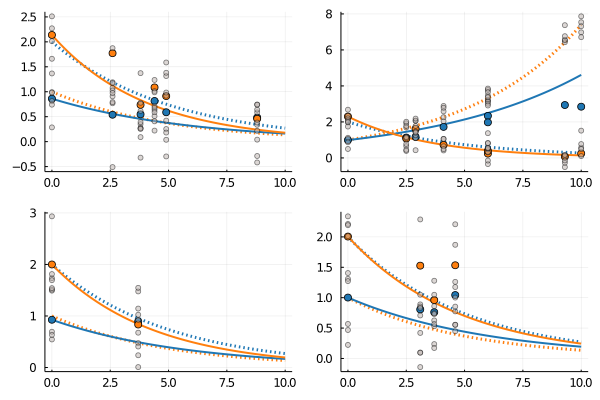

96.75248169186098


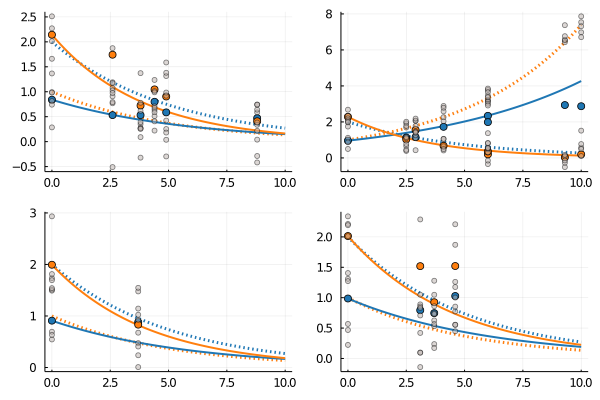

mean(L.(xs, x_baseline, tvals)) = 95.08556008727166
mean(L.(xs, x_baseline, tvals)) = 

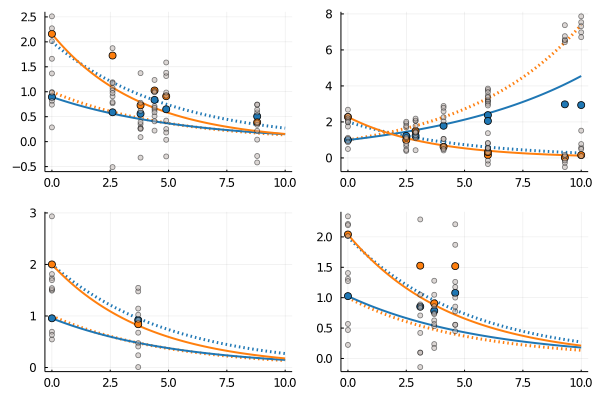

95.11224071952459


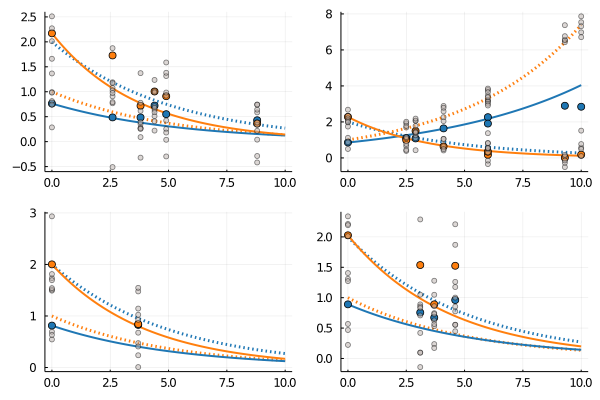

mean(L.(xs, x_baseline, tvals)) = 93.22267119967356
mean(L.(xs, x_baseline, tvals)) = 

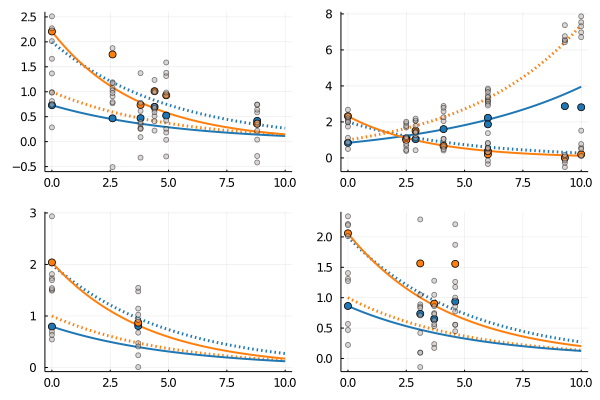

92.61527236691406


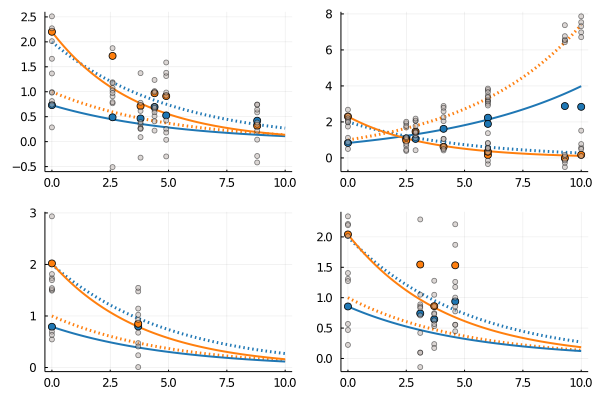

mean(L.(xs, x_baseline, tvals)) = 91.77996410422223
mean(L.(xs, x_baseline, tvals)) = 

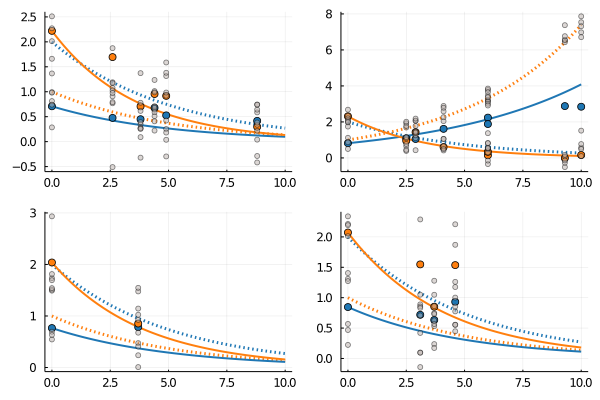

91.30890041846025


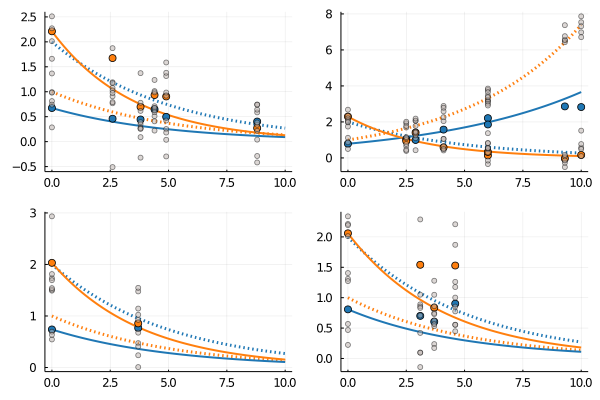

mean(L.(xs, x_baseline, tvals)) = 91.54374967123398
mean(L.(xs, x_baseline, tvals)) = 

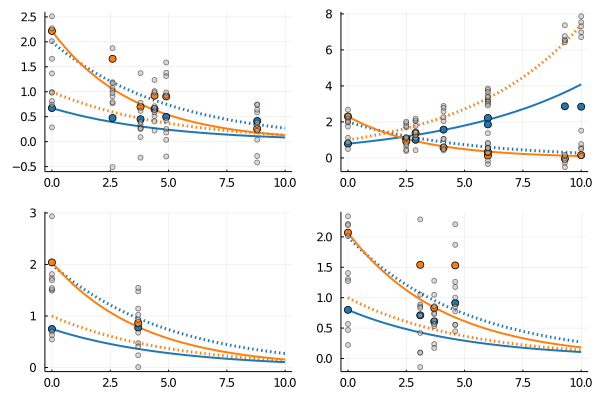

90.59854836626724


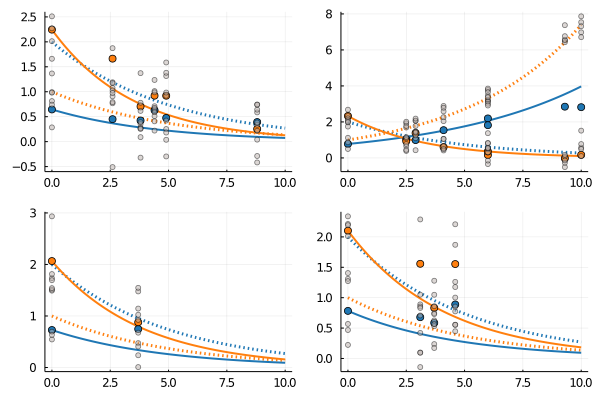

mean(L.(xs, x_baseline, tvals)) = 89.73658070519821
mean(L.(xs, x_baseline, tvals)) = 

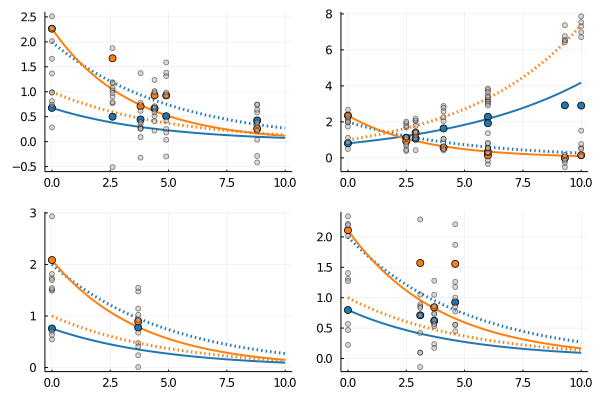

89.4351604173553


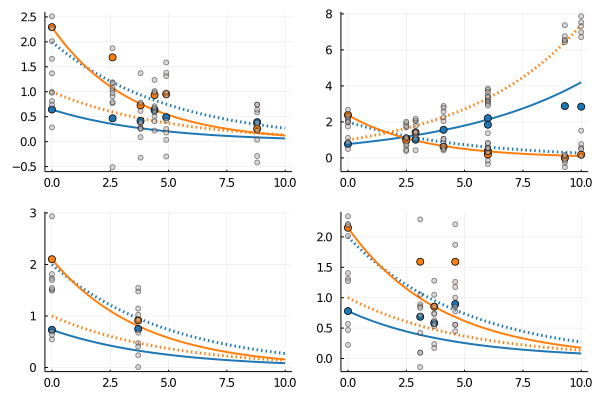

mean(L.(xs, x_baseline, tvals)) = 89.45929962557193
mean(L.(xs, x_baseline, tvals)) = 

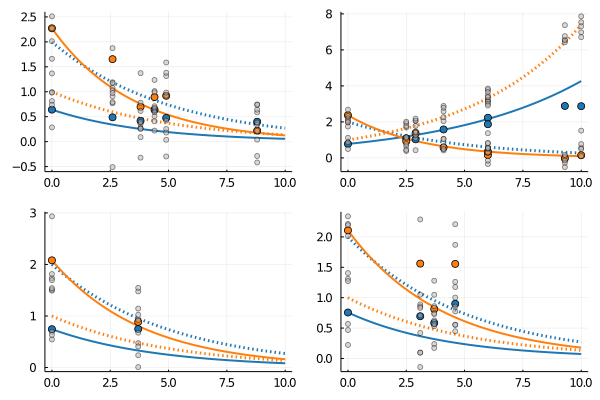

88.03523778438425


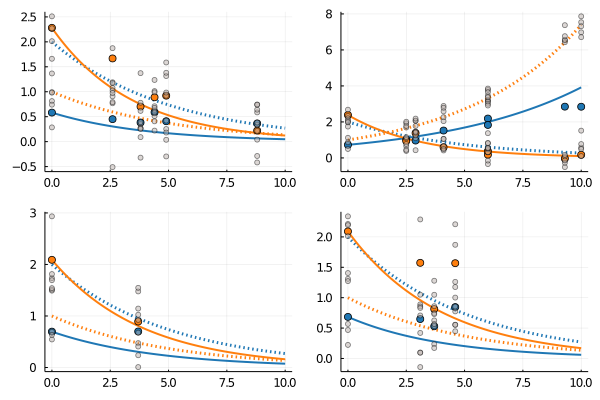

mean(L.(xs, x_baseline, tvals)) = 88.22061616665182
mean(L.(xs, x_baseline, tvals)) = 

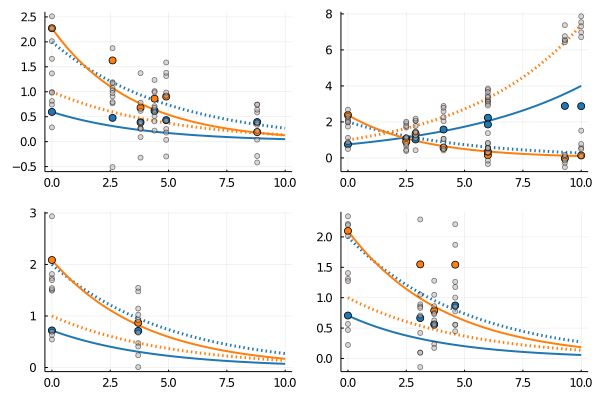

87.04584991603593


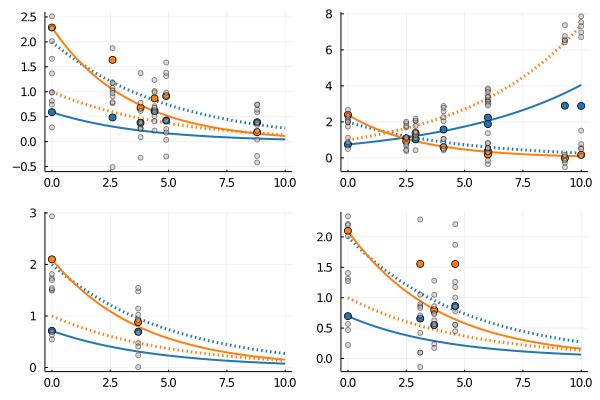

mean(L.(xs, x_baseline, tvals)) = 86.70620256261431
mean(L.(xs, x_baseline, tvals)) = 

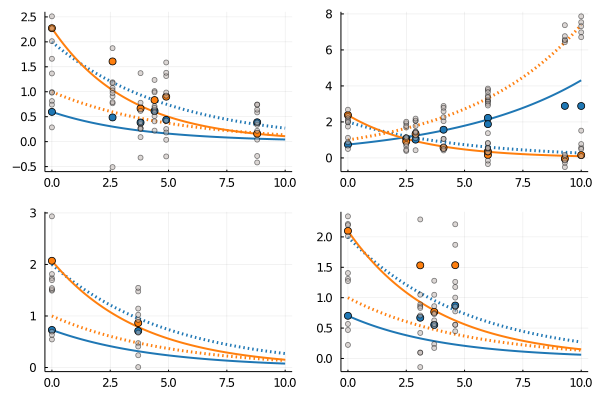

87.47302495168331


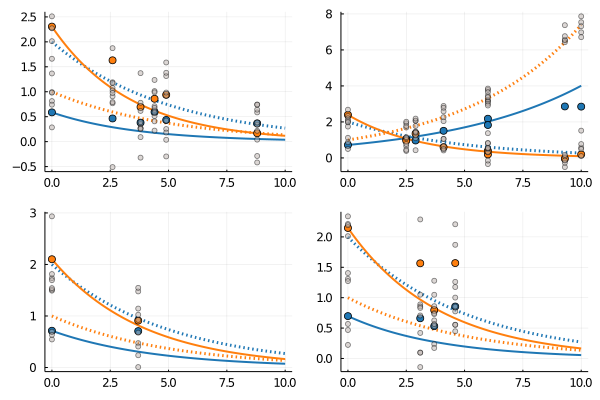

mean(L.(xs, x_baseline, tvals)) = 85.73361462340968
mean(L.(xs, x_baseline, tvals)) = 

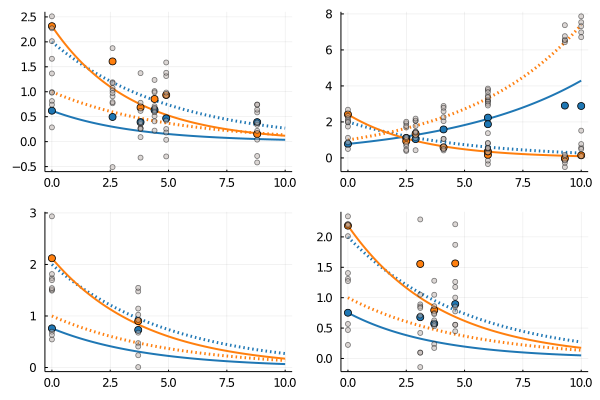

86.39204660498918


In [14]:
for i in 1:40
    Flux.train!(L, ps, trainingdata, opt)
    evalcb()
    evalcb_zs()
end

## Look at the results 

We can now visualize what the model has learnt, by looking at the fitted trajectories in each of the two groups from each individual (thin solid lines in the plot) and compare them to the ground-truth solutions (dashed thicker lines). Additionally, we can visually evaluate how well the latent representations before and after solving the ODE match by comparing the dots (=latent representation means obtained directly from the encoder) with the solid lines (latent fitted ODE solutions). 

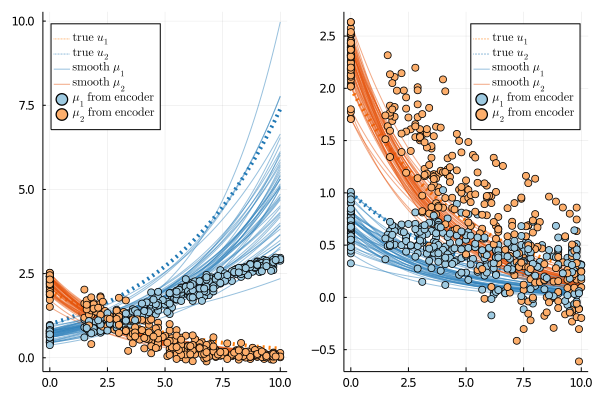

In [15]:
data = simdata(xs, x_baseline, tvals, group1, group2);

plot(allindsplot(2, data, m, sol_group1, sol_group2),
    allindsplot(1, data, m, sol_group1, sol_group2),
    layout = (1,2)
)